In this notebook, we will explore:
- How it reads tokens (tokenizer)?
- How it represents tokens as vectors (embeddings)?
- How these embeddings will eventually be used for attention and prediction?

# Tokenization
- The model can’t read words directly — it only understands numbers. So we need to convert text → tokens → numbers.
- tokenize() splits into sub-word pieces.
- encode() converts them into numeric IDs.
- decode() reverses the process.

In [ ]:
from transformers import AutoTokenizer

# Load a small open model's tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

text = "Small Language Models are powerful and efficient!"
tokens = tokenizer.tokenize(text)
ids = tokenizer.encode(text)

print("Original text:", text)
print("Tokens:", tokens)
print("Token IDs:", ids)
print("Decoded back:", tokenizer.decode(ids))

Original text: Small Language Models are powerful and efficient!
Tokens: ['Small', 'ĠLanguage', 'ĠModels', 'Ġare', 'Ġpowerful', 'Ġand', 'Ġefficient', '!']
Token IDs: [18712, 15417, 32329, 389, 3665, 290, 6942, 0]
Decoded back: Small Language Models are powerful and efficient!


## A Simple Tokenizer Implementation (Toy Tokenizer)

In [ ]:
import re

def basic_tokenizer(text):
    # Lowercase + split on spaces & punctuation
    text = text.lower()
    tokens = re.findall(r"\w+|[^\w\s]", text)
    return tokens

sample_text = "Small Language Models are powerful and efficient!"
tokens = basic_tokenizer(sample_text)
print(tokens)
    

['small', 'language', 'models', 'are', 'powerful', 'and', 'efficient', '!']


## Real GPT-2 BPE tokenizer
1. GPT-2 uses subword tokenization (Byte Pair Encoding, BPE) to handle rare words efficiently.
2. Tokens are not always whole words; BPE splits or merges based on frequency.
3. The tokenizer’s vocabulary is fixed, built before model training. 
   Tokenizer training is often done on a subset of the full corpus (e.g., 1–10% of data), if the corpus is extremely large, to save time.
   The subset must be representative of all text the model will encounter.
   The vocabulary generated is then fixed and used throughout model training.

### Analogy
- Think of the vocabulary as a dictionary for the model.
- You want the dictionary to cover all common words in the language you’re going to teach the model.
- Making a dictionary from Shakespeare when you’re training on Wikipedia would work poorly — it won’t reflect the frequency of words in Wikipedia.

In [ ]:
from transformers import AutoTokenizer

# Load GPT-2 tokenizer (uses real BPE)
hf_tokenizer = AutoTokenizer.from_pretrained("gpt2")

text = "Small Language Models are powerful and efficient!"
tokens_hf = hf_tokenizer.tokenize(text)
ids_hf = hf_tokenizer.encode(text)

print("Original text:", text)
print("\nHugging Face BPE Tokens:", tokens_hf)
print("Token IDs:", ids_hf)
print("Decoded back:", hf_tokenizer.decode(ids_hf))
# Decoding some random token ID - Prints a word referred in the tokenizer vocabulary
print("Random Token:", hf_tokenizer.decode(18710))  

Original text: Small Language Models are powerful and efficient!

Hugging Face BPE Tokens: ['Small', 'ĠLanguage', 'ĠModels', 'Ġare', 'Ġpowerful', 'Ġand', 'Ġefficient', '!']
Token IDs: [18712, 15417, 32329, 389, 3665, 290, 6942, 0]
Decoded back: Small Language Models are powerful and efficient!
Random Token:  Hollow


# Embeddings
## Definition of embedding:
* Numerical vector representing an object (word, token, or sentence) in high-dimensional space.
* Similar objects → vectors close together; dissimilar → far apart.

## Purpose in Transformers / LLMs:
* Converts symbolic text into numbers so the model can process it.
* Captures semantic meaning and, in last_hidden_state, contextual meaning.

### Example:
Text: "Small Language Models"
Tokens: ["Small", "ĠLanguage", "ĠModels"]
Each token → 768-dimensional vector (GPT-2 small).

## Why embeddings are important:
* Provide contextualization: combined with attention, the model “understands” meaning in context.
* Allow semantic similarity: similar words (e.g., “king” & “queen”) have similar vectors.
* Serve as the starting point for downstream tasks: next-token prediction, classification, etc.

### Analogy:
* Think of a map of cities
* Each city = token
* Coordinates = embedding vector
* Nearby cities = similar meaning
* Moving through the map = attention + feed-forward layers updating embeddings

### last_hidden_state:
* Tensor of shape [batch_size, seq_len, hidden_size]
* Each token has a contextualized embedding vector after passing through Transformer layers.
* Before passing through layers → embeddings are basic numeric representations of tokens.
* After layers → embeddings are contextualized, rich representations used for predictions.


In [ ]:
# Extract Embeddings from GPT-2
import torch
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2")

text = "Small Language Models are powerful and efficient!"
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state  # shape: [batch_size, seq_len, hidden_size]

print("Embedding shape:", embeddings.shape)
print("Number of tokens:", embeddings.shape[1])
print("Hidden size:", embeddings.shape[2])


Embedding shape: torch.Size([1, 8, 768])
Number of tokens: 8
Hidden size: 768


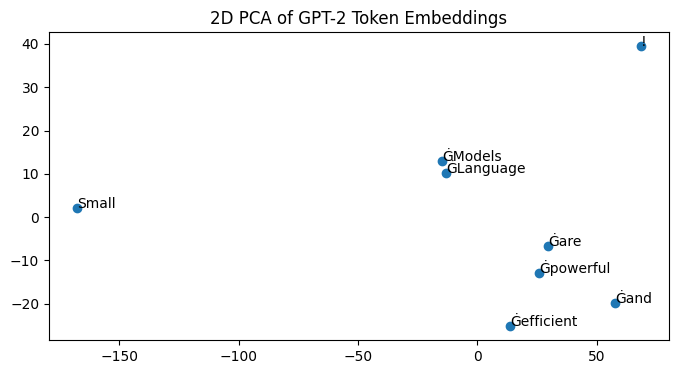

In [8]:
# Visualizing Embeddings with PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

tokens = tokenizer.tokenize(text)
emb_np = embeddings[0].numpy()  # convert from tensor to numpy

# Reduce 768-d to 2D
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb_np)

plt.figure(figsize=(8,4))
plt.scatter(emb_2d[:,0], emb_2d[:,1])
for i, token in enumerate(tokens):
    plt.annotate(token, (emb_2d[i,0], emb_2d[i,1]))
plt.title("2D PCA of GPT-2 Token Embeddings")
plt.show()


# Positional Encoding
Transformers don’t process words sequentially like RNNs.
So they need to know where each token is in the sentence.

They add a positional vector (e.g., sine/cosine pattern or learned embedding)
so “The cat” ≠ “cat The”.

Result = (embedding + position) for each token.

## Understanding & Visualizing Attention (GPT-2)

### 📘 Model Context
- **Model:** `GPT-2` (decoder-only Transformer)
- **Architecture:** 12 layers × 12 attention heads  
- **Attention type:** *Causal self-attention* → each token can only attend to **previous** tokens (no future look-ahead)

---

### 🔍 What the Heatmap Shows
- **Rows (Y-axis):** Query tokens — the ones *attending*  
- **Columns (X-axis):** Key tokens — the ones *being attended to*  
- **Bright cells:** High attention weight → strong focus/relationship  
- **Diagonal line:** Each token attends to itself (self-attention)  
- **Dark upper triangle:** Causal mask (future tokens are hidden)

---

### 🧩 Data Shapes
- `attentions[layer]` → shape `[batch, heads, seq_len, seq_len]`  
  - Each entry = one attention matrix for a single head  
- `last_hidden_state` → contextualized token embeddings  
- `attentions` → relationships between tokens (who “looks” at whom)

---

### 🎨 Visualization Settings
- Color map: `"magma"` for strong contrast  
- Log scale: `np.log1p(attention)` to highlight smaller differences  
- Color range: `vmin=0.0`, `vmax≈0.15–0.25` to make bright regions pop  
- Convert tensor before plotting:  
  ```python
  attention = attention.cpu().numpy()


Layers: 12 | Heads per layer: 12


/var/folders/r2/99tskl0j3ns23ltqf6zbg7yc0000gn/T/ipykernel_4457/2177182402.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sns.heatmap(np.log1p(attention), xticklabels=tokens, yticklabels=tokens, cmap="magma", square=True, vmin=0.0, vmax=0.15)


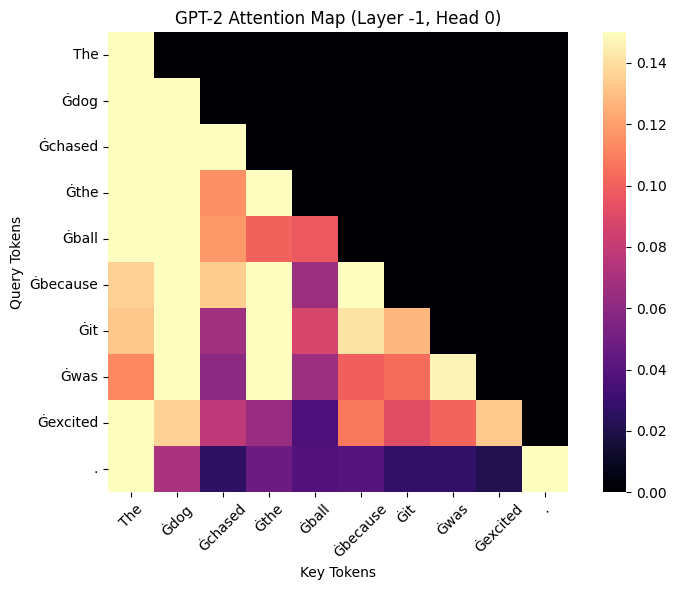

In [34]:
# Understanding & Visualizing Attention (GPT-2)
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True)
model.eval()

sentence = "The dog chased the ball because it was excited."
inputs = tokenizer(sentence, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attentions = outputs.attentions  # list: one tensor per layer
print(f"Layers: {len(attentions)} | Heads per layer: {attentions[0].shape[1]}")

# Visualize one attention head from the last layer
layer = -1  # last layer
head = 0   # first attention head

attention = attentions[layer][0, head].cpu()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

plt.figure(figsize=(8,6))
sns.heatmap(np.log1p(attention), xticklabels=tokens, yticklabels=tokens, cmap="magma", square=True, vmin=0.0, vmax=0.15)
plt.title(f"GPT-2 Attention Map (Layer {layer}, Head {head})")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
